Environment: Gridworld

Task: Get to some point X (given). Avoid red spots (some points are red and the agent doesn’t wanna go on those).

### Info:
GRID: 7 by 5 \
Number of red spots: 4 \
Positions of red spots: red1, red2, red3, red4 = (randomly define locations for each one) \
Red_spots = [(1, 2), (6, 1), (3, 2), (4, 4)]

### S
Location of Agent \
    Agent_pos = (x, y)

Locations of Red Spots: \
Agent Map = Belixef of Possible Locations on Grid \
    Possible_locations = dict((1,1) : False) \
        1st component = location \
        2nd component encodes whether it’s a red spot (true) or safe (false)

### T
Location of Agent \
    Environmental Constraints \
        If agent_pos[0] == 0: P(a = LEFT) = 0  \
        If agent_pos[1] == 0: P(a = DOWN) = 0  \
        If agent_pos[0] ==  6: P(a = RIGHT) = 0  \
        If agent_pos[1] == 4: P(a = UP) = 0 \
If a == RIGHT: agent_pos[0] += 1 \
If a == LEFT: agent_pos[0] -= 1 \
If a == UP: agent_pos[1] += 1 \
If a == DOWN: agent_pos[1] -= 1

### R
Reward_points = 0 \
Redspot: If agent_pos in redspots: reward_points -= 5 \
Endgoal \
    If agent_pos == (4, 6): reward_points += 20


### set of observations (dimensionality of 2)
Observation \
    Observed_spot \
        ((x, y), True/False) \
    Possible_locations.append(observed_spot)

O is set of conditional observation probabilities (prior preference) \
    C = C matrix \
    C[(4,6)] = 1

## Imports

In [55]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import seaborn as sns

import pymdp
from pymdp import utils

## Auxilary Functions

In [56]:
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_likelihood(matrix, title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

## Parameters

In [57]:
# grid_dimensions
grid_dims = [7,5]
num_grid_points = np.prod(grid_dims) # total number of grid locations (rows X columns)

# setup matrix
grid = np.arange(num_grid_points).reshape(grid_dims) # arange -> creates list; reshape -> makes it in the shape specified by grid_dims

# define red spots
grid[(1, 2)] = 1
grid[(3, 2)] = 1
grid[(4, 4)] = 1
grid[(6, 1)] = 1

# list of grid positiions
grid_locations = []
it = np.nditer(grid, flags=["multi_index"]) # set up the iterator to go throgh the matrix
while not it.finished:
    grid_locations.append(it.multi_index)
    it.iternext()

grid, grid_locations

redspots = [(1,2), (3,2), (4,4), (6,1)]

In [58]:
# location of the agent hidden state
agent_pos = (0,0)

goal_location = (6,4)

## Visual gridworld

### Set up figure & grid
fig: The entire figure (canvas) where the grid and visual elements will be plotted; ax: The specific axis (plot area) for drawing the grid.

In [59]:
# fig, ax = plt.subplots(figsize=(10, 6))

Next step is to create the visual grid. \
np.meshgrid defines/creates it. \
The other functions are purely visuals. \
FIGURE OUT WHY WE HAVE TO REDEFINE IT LATER

In [60]:
# fig, ax = plt.subplots(figsize=(8, 6))  # Properly sized figure

# # Create grid
# X, Y = np.meshgrid(np.arange(grid_dims[1] + 1), np.arange(grid_dims[0] + 1))  # 5x7 grid
# h = ax.pcolormesh(X, Y, np.zeros(grid_dims), edgecolors='k', linewidth=3, cmap='coolwarm')  # Base grid

# # Add goal (green square)
# ax.add_patch(
#     plt.Rectangle((4, 6), width=1, height=1, color='green')  # Adjusted coordinates for grid alignment
# )

# # Add red obstacles
# red_obstacles = [(2, 1), (1, 6), (2, 3), (4, 4)]  # List of (x, y) coordinates for red obstacles
# for red in red_obstacles:
#     ax.add_patch(
#         plt.Rectangle((red[0], red[1]), width=1, height=1, color='red')
#     )

# # Add entry point (white square)
# ax.add_patch(
#     plt.Rectangle((0, 0), width=1, height=1, color='white')
# )

# # Add agent (black circle)
# ax.add_patch(
#     plt.Circle((agent_pos[0] + 0.5, agent_pos[1] + 0.5), radius=0.25, color='black')
# )

# # Set grid limits and labels
# ax.set_xlim(0, grid_dims[1])
# ax.set_ylim(0, grid_dims[0])
# ax.set_aspect('equal')
# ax.set_xticks(np.arange(grid_dims[1]) + 0.5)
# ax.set_yticks(np.arange(grid_dims[0]) + 0.5)
# ax.set_xticklabels(np.arange(grid_dims[1]))
# ax.set_yticklabels(np.arange(grid_dims[0]))
# plt.gca().invert_yaxis()  # Invert y-axis to match typical grid orientation

# # Show plot
# plt.show()



In [61]:
# fig, ax = plt.subplots(figsize=(10, 6)) # idk why we need to redefine this. FIGURE IT OUT LATER

# # create grid
# X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
# print(X, Y)
# # grid visuals
# h = ax.pcolormesh(X, Y, np.ones([5, 7]), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')

# # goal
# desired_location = ax.add_patch(
#     plt.Rectangle((4, 6), width=1, height=1, color='green')
# )

# # red spots
# red1 = ax.add_patch(
#     plt.Rectangle((1, 2), width=1, height=1, color='red')
# )
# red2 = ax.add_patch(
#     plt.Rectangle((6, 1), width=1, height=1, color='red')
# )
# red3 = ax.add_patch(
#     plt.Rectangle((3, 2), width=1, height=1, color='red')
# )
# red4 = ax.add_patch(
#     plt.Rectangle((4, 4), width=1, height=1, color='red')
# )

# # entry spot
# entry = ax.add_patch(
#     plt.Rectangle((0, 0), width=1, height=1, color='white')
# )
# agent_icon = ax.add_patch(
#     plt.Circle((agent_pos[0] + 0.5, agent_pos[1] + 0.5), radius=0.25, color='black')
# )


# desired_location = ax.add_patch(
#     plt.Rectangle((6, 4), width=1, height=1, color='green')
# )

# # ax.set_xlim(0, grid_dims[1])
# # ax.set_ylim(0, grid_dims[0])
# # ax.set_aspect('equal')
# # ax.set_xticks(np.arange(grid_dims[1]) + 0.5)
# # ax.set_yticks(np.arange(grid_dims[0]) + 0.5)
# # ax.set_xticklabels(np.arange(grid_dims[1]))
# # ax.set_yticklabels(np.arange(grid_dims[0]))

# plt.show()

## Generative Model

In [62]:
# # reward
# reward_conditions_positive = ['END GOAL']
# reward_locations_positive = [(6,4)]
# reward_conditions_negative = ['RED1', 'RED2', 'RED3', 'RED4']
# reward_locations_negative = [(1, 2), (6, 1), (3, 2), (4, 4)]

In [63]:
# context_names = ['SAFE', 'RED']
# choice_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

# num_states = [len(context_names), len(choice_names)]
# num_factors = len(num_states)

# context_action_names = ['Do-nothing']
# choice_action_names = ['Move-up', 'Move-down', 'Move-left', 'Move-right']

# num_controls = [len(context_action_names), len(choice_action_names)]

# loc_obs_attributes = ['SAFE', 'DANGER', 'GOAL']
# # agent's belief about map hidden state
# map_obs = {
#     (0,0) : False,
#     (0, 1) : False,
#     (1, 0) : False,
#     (1, 1) : False,
# }

# num_obs = [len(loc_obs_attribute), len(loc_obs_map)]
# num_modalities = len(num_obs)

The hidden states s have these hidden state factors:
1. Location (as many levels as there are grid locations)

The observations!!:
1. Positions
2. Safety (2 hidden state levels - safe or dangerous/red)

In [64]:
num_states = [len(grid_locations)] # location

safety = ['EMPTY', 'RED'] # obs
goal = ['EMPTY', 'GOAL']

num_obs = [len(grid_locations), len(safety), len(goal)]


### A Array

In [65]:
A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs] # list of shapes of modality-specific A[m] arrays
A = utils.obj_array_zeros(A_m_shapes) # initialize A array to an object array of all-zero subarrays
A_m_shapes # 2 types of observations, one type of state

[[35, 35], [2, 35], [2, 35]]

Location observation modality: A[0]

In [66]:
# A[0] = np.eye(num_grid_points)

# # Safety observations (probability 1 for the safe state, 0 for the dangerous one)
# A[1] = np.zeros((2, num_grid_points))  # safety matrix initialized to 0
# A[1][0, 0] = 1  # Safe state (SAFE) for the first grid point, probability 1
# A[1][1, 0] = 0  # Danger (RED) for the first grid point, probability 0

# A[2][0, 0] = 1

In [67]:
A = utils.obj_array_zeros(A_m_shapes)
A[0] = np.eye(num_grid_points)  # Location observations (one-hot encoded)

# Safety observations
A[1] = np.zeros((2, num_grid_points))
A[1][0, 0] = 1  # Safe state probability
A[1][1, 0] = 0  # Danger state probability

# For remaining columns in A[1], we need to set probabilities
# Let's say for now all other states are "safe"
A[1][0, 1:] = 1  # Set all other states as safe
A[1][1, 1:] = 0  # Set all other states as not dangerous

# Do the same for A[2]
A[2] = np.zeros((2, num_grid_points))
A[2][0, 0] = 1
A[2][1, 0] = 0
A[2][0, 1:] = 1
A[2][1, 1:] = 0

# Verify normalization
for modality in range(len(A)):
    column_sums = np.sum(A[modality], axis=0)
    print(f"Modality {modality} column sums before check:", column_sums)
    
    # Each column should sum to 1
    assert np.allclose(column_sums, 1.0), f"Modality {modality} is not normalized"

Modality 0 column sums before check: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Modality 1 column sums before check: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Modality 2 column sums before check: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


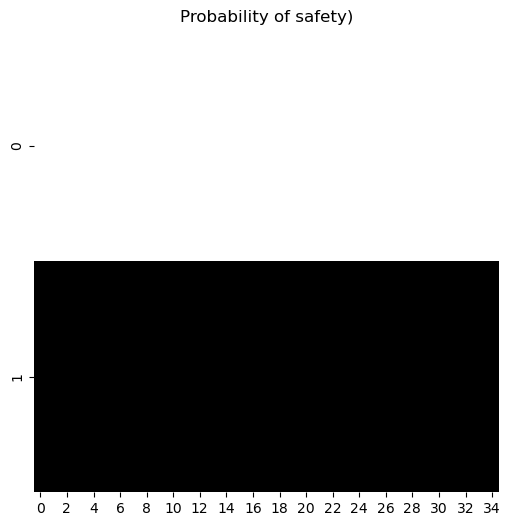

In [68]:
plot_likelihood((A[2]), title_str = 'Probability of safety)')

In [69]:
# A = utils.obj_array(num_modalities)

# p_safe = 0.5
# p_danger = 1 - p_safe

# A_loc_attribute = np.zeros((len(loc_obs_attributes), len(context_names), len(choice_names)))

# for choice_id, choice_name in enumerate(choice_names):
#     if choice_name == 'UP':
#         A_loc_attribute[0,:,choice_id] =  

### B Array

In [70]:
num_controls = [5]
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]
B = utils.obj_array_zeros(B_f_shapes)
B_f_shapes


[[35, 35, 5]]

In [71]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

for action_id, action_label in enumerate(actions):

  for curr_state, grid_location in enumerate(grid_locations):

    y, x = grid_location

    if action_label == "UP":
      next_y = y - 1 if y > 0 else y 
      next_x = x

    elif action_label == "DOWN":
      next_y = y + 1 if y < (grid_dims[0]-1) else y 
      next_x = x
    elif action_label == "LEFT":
      next_x = x - 1 if x > 0 else x 
      next_y = y
    elif action_label == "RIGHT":
      next_x = x + 1 if x < (grid_dims[1]-1) else x 
      next_y = y
    elif action_label == "STAY":
      next_x = x
      next_y = y

    new_location = (next_y, next_x)
    next_state = grid_locations.index(new_location)
    B[0][next_state, curr_state, action_id] = 1.0

### C Vectors (prior preferences)

In [72]:

C = utils.obj_array_zeros(num_obs)  # Initialize C array with shape matching num_obs

# Set preferences for state observations (location)
C[0] = np.zeros(len(grid_locations))

# Set preferences for safety observations
C[1] = np.zeros(len(safety))
C[1][1] = -5.0  # Negative preference for red spots

# Set preferences for goal observations
C[2] = np.zeros(len(goal))
C[2][1] = 20.0  # Positive preference for reaching the goal


In [73]:
# C = utils.obj_array_zeros(num_obs)

# C[1][1] = -5 # negative preference for red spots (punishment)
# C[2][1] = 20 # preference for end goal (reward)

### D Vectors: Prior over (initial) hidden states

In [74]:
D = utils.obj_array_uniform(num_states)
D[0] = utils.onehot(grid_locations.index((0,0)), len(grid_locations))

# Generative Process

In [75]:
def update_vision(current_location, grid_dims, distance):
    """
    Update the agent's field of vision based on the current location and distance
    Returns a list of all grid positions within the vision range
    
    Args:
        current_location (tuple): Current (y,x) position of the agent
        grid_dims (list): Dimensions of the grid [height, width]
        distance (int): Vision range/distance
        
    Returns:
        list: List of (y,x) tuples representing visible grid positions
    """
    y, x = current_location
    y_min = max(0, y - distance)
    y_max = min(grid_dims[0], y + distance + 1)
    x_min = max(0, x - distance)
    x_max = min(grid_dims[1], x + distance + 1)
    
    visible_locations = []
    for y_pos in range(y_min, y_max):
        for x_pos in range(x_min, x_max):
            visible_locations.append((y_pos, x_pos))
            
    return visible_locations

In [106]:
X, Y = 0, 0

class GridWorldEnv():

    def __init__(self, starting_loc = (0, 0), red1_loc = (1, 2), red2_loc = (3,2), red3_loc = (4,4), red4_loc = (6, 1), goal = (6 ,4)):
        self.init_loc = starting_loc
        self.current_location = self.init_loc
        Y, X = self.current_location

        self.red1_loc = red1_loc
        self.red2_loc = red2_loc
        self.red3_loc = red3_loc
        self.red4_loc = red4_loc
        self.redspots = [self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc]

        self.goal = goal

        self.red_obs = ['Null']
        self.goal_obs = 'Null'
        self.empty_obs = ['Null']

        self.agent_reward = 0

        print(f"Starting location is {self.init_loc} | Red spot locations are {self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc} | Goal is {self.goal}")
    
    def step(self, action_label):

        Y, X = self.current_location

        if action_label == "DOWN": 
          if Y < grid_dims[0] - 1: Y_new = Y + 1
          else: Y_new = Y
          X_new = X

        elif action_label == "UP": 
        
          if Y > 0: Y_new = Y - 1
          else: Y_new = Y
          X_new = X

        elif action_label == "LEFT": 
          
          if X > 0: X_new = X - 1
          else: X_new = X
          Y_new = Y

        elif action_label == "RIGHT": 
          
          if X < grid_dims[1] - 1: X_new = X + 1
          else: X_new = X
          Y_new = Y

        elif action_label == "STAY":
          Y_new, X_new = Y, X
        
        X, Y = X_new, Y_new
        current_location = (Y_new, X_new) # store the new grid location
        self.vision = update_vision(current_location, grid_dims, 7)

        loc_obs = self.current_location # agent directly observes its position in grid


        for spot in self.vision:
            if spot in self.redspots:
                if 'Null' in self.red_obs:
                    self.red_obs = [spot]
                else:
                    self.red_obs.append(spot)
            elif spot == self.goal:
                self.goal_obs = spot
            else:
                if 'Null' in self.empty_obs:
                    self.empty_obs = [spot]
                else:
                    self.empty_obs.append(spot)


        if self.current_location in self.redspots:
            self.agent_reward -= 5
            if 'Null' in self.red_obs:
                self.red_obs = [self.current_location]
            else:
                self.red_obs.append(self.current_location)
        elif self.current_location == self.goal:
            self.agent_reward += 20
            self.goal_obs = current_location
        else:
            if 'Null' in self.empty_obs:
                self.empty_obs = [self.current_location]
            else:
                self.empty_obs.append(self.current_location)
        
        return self.agent_reward, self.loc_obs, self.goal_obs, self.empty_obs, self.red_obs
    
    def reset(self):
        self.current_location = self.init_loc
        print(f'Re-initialized location to {self.init_loc}')
        self.loc_obs = self.current_location
        self.goal_obs, self.empty_obs, self.red_obs, self.agent_reward = 'Null', ['Null'], ['Null'], 0

        return self.loc_obs, self.goal_obs, self.empty_obs, self.red_obs, self.agent_reward

# Active Inference

In [107]:
from pymdp.agent import Agent

In [108]:
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 4)

my_env = GridWorldEnv(starting_loc = (0, 0), red1_loc = (1, 2), red2_loc = (3,2), red3_loc = (4,4), red4_loc = (6, 1), goal = (6 ,4))

loc_obs, goal_obs, empty_obs, red_obs, agent_reward = my_env.reset()

Starting location is (0, 0) | Red spot locations are ((1, 2), (3, 2), (4, 4), (6, 1)) | Goal is (6, 4)
Re-initialized location to (0, 0)


In [109]:
loc_obs, goal_obs, empty_obs, red_obs, agent_reward

((0, 0), 'Null', ['Null'], ['Null'], 0)

In [110]:
history_of_locs = [loc_obs]

T = 10

for t in range(T):

    # Feed Observations ft. infer_states function
    for spot in grid_locations:
        obs = [grid_locations.index(spot)]

        # spot, safety, goal
        if spot in red_obs:
            obs.append(1)
        else:
            obs.append(0)
        
        if spot == goal_obs:
            obs.append(1)
        else:
            obs.append(0)

        qs = my_agent.infer_states(obs)
    
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    print(f'Action at time {t}: {choice_action}')

    
    agent_reward, loc_obs, goal_obs, empty_obs, red_obs = my_env.step(choice_action)
    
    print(agent_reward, loc_obs, goal_obs, empty_obs, red_obs)


    history_of_locs.append(loc_obs)

    print(f'Grid location at time {t}: {loc_obs}')

    print(f'Reward at time {t}: {agent_reward}')

Action at time 0: UP
0 (0, 0) (6, 4) [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 2), (6, 3), (0, 0)] [(1, 2), (3, 2), (4, 4), (6, 1)]
Grid location at time 0: (0, 0)
Reward at time 0: 0
Action at time 1: DOWN
0 (0, 0) (6, 4) [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 2), (6, 3), (0, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 2), (6, 3), (0, 0)] [(1, 2), (3, 2), (4, 4), (6, 1), (1, 2), (3, 2), (4, 4), (6, 1)]
Grid location at time 1: (0,